<a href="https://colab.research.google.com/github/Yuji-ONUKI/GCI2020_Winter/blob/main/July02_0300_0_7445.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

print('Importing data...')

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/train.csv")
test = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/test.csv")

Importing data...
Mounted at /content/drive


In [2]:
# Create an anomalous flag column
data['DAYS_EMPLOYED_ANOM'] = data["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# Create an anomalous flag column
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [3]:
data['RT_CREDIT']=data['AMT_CREDIT']/data['AMT_INCOME_TOTAL']
test['RT_CREDIT']=test['AMT_CREDIT']/test['AMT_INCOME_TOTAL']

In [4]:
n=100
data['RT_CREDIT']=round(data['RT_CREDIT']*n)/n
len(data['RT_CREDIT'].unique())

1787

In [5]:
cols =list(test.columns)
cols

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHA

In [6]:
data['YEARS_BIRTH']=round(data['DAYS_BIRTH']/365)
test['YEARS_BIRTH']=round(test['DAYS_BIRTH']/365)

data['YEARS_ID_PUBLISH']=round(data['DAYS_ID_PUBLISH']/365)
test['YEARS_ID_PUBLISH']=round(test['DAYS_ID_PUBLISH']/365)

data['YEARS_REGISTRATION']=round(data['DAYS_REGISTRATION']/365)
test['YEARS_REGISTRATION']=round(test['DAYS_REGISTRATION']/365)

data['YEARS_EMPLOYED']=round(data['DAYS_EMPLOYED']/365)
test['YEARS_EMPLOYED']=round(test['DAYS_EMPLOYED']/365)

In [7]:
data['AGE_EMP']=data['YEARS_BIRTH']-data['YEARS_EMPLOYED']
test['AGE_EMP']=test['YEARS_BIRTH']-test['YEARS_EMPLOYED']

# 26歳までの上昇局面とそれ以降の下降局面を別のカラムにする
data['AGE_EMP1']=np.NAN
test['AGE_EMP1']=np.NAN
data.loc[data['AGE_EMP']<-26,'AGE_EMP1']=data['AGE_EMP']
test.loc[test['AGE_EMP']<-26,'AGE_EMP1']=test['AGE_EMP']
data.loc[data['AGE_EMP']<-26,'AGE_EMP']=np.NAN
test.loc[test['AGE_EMP']<-26,'AGE_EMP']=np.NAN

In [8]:
data.loc[data['REGION_POPULATION_RELATIVE']>0.04,'REGION_POPULATION_RELATIVE'].unique()

array([0.072508, 0.04622 ])

In [9]:
data['REGION_POPULATION_RELATIVE_0.04622']=0
data['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE_0.04622']=1
data['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE']=np.nan

test['REGION_POPULATION_RELATIVE_0.04622']=0
test['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE_0.04622']=1
test['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE']=np.nan

data['REGION_POPULATION_RELATIVE_0.072508']=0
data['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE_0.072508']=1
data['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE']=np.nan

test['REGION_POPULATION_RELATIVE_0.072508']=0
test['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE_0.072508']=1
test['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE']=np.nan

In [10]:
data['OWN_CAR_AGE_64']=0
data['OWN_CAR_AGE'==64,'OWN_CAR_AGE_64']=1
data['OWN_CAR_AGE'==64,'OWN_CAR_AGE']=np.nan

test['OWN_CAR_AGE_64']=0
test['OWN_CAR_AGE'==64,'OWN_CAR_AGE_64']=1
test['OWN_CAR_AGE'==64,'OWN_CAR_AGE']=np.nan

data['OWN_CAR_AGE_65']=0
data['OWN_CAR_AGE'==65,'OWN_CAR_AGE_65']=1
data['OWN_CAR_AGE'==65,'OWN_CAR_AGE']=np.nan

test['OWN_CAR_AGE_65']=0
test['OWN_CAR_AGE'==65,'OWN_CAR_AGE_65']=1
test['OWN_CAR_AGE'==65,'OWN_CAR_AGE']=np.nan

In [11]:
data['LOW_DEFAULT_ORG']=0
data.loc[data['ORGANIZATION_TYPE']=='Industry: type 12','LOW_DEFAULT_ORG' ]=1
data.loc[data['ORGANIZATION_TYPE']=='Trade: type 4','LOW_DEFAULT_ORG' ]=1
test['LOW_DEFAULT_ORG']=0
test.loc[test['ORGANIZATION_TYPE']=='Industry: type 12','LOW_DEFAULT_ORG' ]=1
test.loc[test['ORGANIZATION_TYPE']=='Trade: type 4','LOW_DEFAULT_ORG' ]=1

data['HIGH_DEFAULT_ORG']=0
data.loc[data['ORGANIZATION_TYPE']=='Transport: type 3','HIGH_DEFAULT_ORG']=1
test['HIGH_DEFAULT_ORG']=0
test.loc[test['ORGANIZATION_TYPE']=='Transport: type 3','HIGH_DEFAULT_ORG']=1

In [12]:
test['CREDIT_INCOME_PERCENT'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
test['ANNUITY_INCOME_PERCENT'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']


In [13]:
dict={}
for item in data['AMT_INCOME_TOTAL'].unique():
  dict[item]=data.loc[data['AMT_INCOME_TOTAL']==item,'SK_ID_CURR'].count()
df = pd.DataFrame.from_dict(dict,orient='index')

items = list(df[df[0]>20])

data['AMT_INCOME_TOTAL_2']=np.NAN
test['AMT_INCOME_TOTAL_2']=np.NAN
for item in items:
  data.loc[data['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL_2']=data.loc[data['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL']
  test.loc[test['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL_2']=test.loc[test['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL']

for item in items:
  data.loc[data['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL']=np.NAN
  test.loc[test['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL']=np.NAN

data['AMT_INCOME_TOTAL']=round(data['AMT_INCOME_TOTAL']/1000)*1000
test['AMT_INCOME_TOTAL']=round(test['AMT_INCOME_TOTAL']/1000)*1000

data.loc[data['AMT_INCOME_TOTAL'].isna(),'AMT_INCOME_TOTAL']=data.loc[data['AMT_INCOME_TOTAL'].isna(),'AMT_INCOME_TOTAL_2']
test.loc[test['AMT_INCOME_TOTAL'].isna(),'AMT_INCOME_TOTAL']=test.loc[test['AMT_INCOME_TOTAL'].isna(),'AMT_INCOME_TOTAL_2']

data.drop(['AMT_INCOME_TOTAL_2'],axis=1,inplace=True)
test.drop(['AMT_INCOME_TOTAL_2'],axis=1,inplace=True)

data=pd.get_dummies(data,columns=['AMT_INCOME_TOTAL'])
test=pd.get_dummies(test,columns={'AMT_INCOME_TOTAL'})

In [14]:
# 欠測値であれば'_NAN'を加えたカラムを作る
def flag_isNan(column_target):
  if type(column_target)==str:
    data[column_target+'_NAN']=0
    test[column_target+'_NAN']=0
    #
    data.loc[data[column_target].isna(),column_target+'_NAN']=1
    test.loc[test[column_target].isna(),column_target+'_NAN']=1

In [15]:
for col in [
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
'EXT_SOURCE_1',
'EXT_SOURCE_2',
'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_EMPLOYED',
 (False, 'REGION_POPULATION_RELATIVE'),
 (False, 'OWN_CAR_AGE')
 ]:
  if (test.loc[test[col].isna(),'SK_ID_CURR'].count()>0):
    flag_isNan(col)

In [16]:
for col in list(test.dtypes[test.dtypes!='float'].keys()):
  if (test.loc[test[col].isna(),'SK_ID_CURR'].count()>0):
    flag_isNan(col)

In [17]:
data['ROUND_RT_CREDIT']=round(data['RT_CREDIT'])
data['ROUND_RT_CREDIT'].fillna(0,inplace=True)
data.loc[data['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
data['ROUND_RT_CREDIT']=data['ROUND_RT_CREDIT'].astype(str)

data=pd.get_dummies(data,columns=['ROUND_RT_CREDIT'])

test['ROUND_RT_CREDIT']=round(test['RT_CREDIT'])
test['ROUND_RT_CREDIT'].fillna(0,inplace=True)
test.loc[test['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
test['ROUND_RT_CREDIT']=test['ROUND_RT_CREDIT'].astype(str)

test=pd.get_dummies(test,columns=['ROUND_RT_CREDIT'])

In [18]:
data['ROUND_EXT_SOURCE_1']=round(data['EXT_SOURCE_1']*100)
data['ROUND_EXT_SOURCE_2']=round(data['EXT_SOURCE_2']*100)
data['ROUND_EXT_SOURCE_3']=round(data['EXT_SOURCE_3']*100)

test['ROUND_EXT_SOURCE_1']=round(test['EXT_SOURCE_1']*100)
test['ROUND_EXT_SOURCE_2']=round(test['EXT_SOURCE_2']*100)
test['ROUND_EXT_SOURCE_3']=round(test['EXT_SOURCE_3']*100)

In [19]:
t1=data.loc[data['TARGET']==1]
t0=data.loc[data['TARGET']==0]
ta=data
def addColumnOfNumber(column_target):
    column_new = 'NEW_NUM_'+column_target
    cats = ta[column_target].unique()

    dict={}
    for cat in cats:
      dict[cat]=(t1.loc[ta[column_target]==cat,'SK_ID_CURR'].count()/ta.loc[ta[column_target]==cat,'SK_ID_CURR'].count()).astype(str)

    data[column_new]=data[column_target]
    test[column_new]=test[column_target]

    data[column_new]=data[column_new].map(dict)
    test[column_new]=test[column_new].map(dict)

    data[column_new]=data[column_new].astype(float)
    test[column_new]=test[column_new].astype(float)

In [20]:
#addColumnOfNumber('REALTY_INCOME_CREDIT')
#addColumnOfNumber('ROUND_EXT_SOURCE_1')
#addColumnOfNumber('ROUND_EXT_SOURCE_2')
#addColumnOfNumber('ROUND_EXT_SOURCE_3')
#data.drop(['ROUND_EXT_SOURCE_1','ROUND_EXT_SOURCE_2','ROUND_EXT_SOURCE_3'],axis=1,inplace=True)
#test.drop(['ROUND_EXT_SOURCE_1','ROUND_EXT_SOURCE_2','ROUND_EXT_SOURCE_3'],axis=1,inplace=True)

In [21]:
#data['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
#test['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

data['YEARS_LAST_PHONE_CHANGE']=round(data['DAYS_LAST_PHONE_CHANGE']/365)
test['YEARS_LAST_PHONE_CHANGE']=round(test['DAYS_LAST_PHONE_CHANGE']/365)

data['MONTH_LAST_PHONE_CHANGE']=round(data['DAYS_LAST_PHONE_CHANGE']/30)
test['MONTH_LAST_PHONE_CHANGE']=round(test['DAYS_LAST_PHONE_CHANGE']/30)

In [22]:
data['CREDIT_TERM'] = data['AMT_CREDIT']/data['AMT_ANNUITY']
test['CREDIT_TERM'] = test['AMT_CREDIT']/test['AMT_ANNUITY']
data['CREDIT_REPAY'] = data['CREDIT_TERM'] *30 + data['DAYS_BIRTH']
test['CREDIT_REPAY'] = test['CREDIT_TERM'] *30 + test['DAYS_BIRTH']

data['NEW_CREDIT_TO_GOODS_RATIO'] = data['AMT_CREDIT'] / data['AMT_GOODS_PRICE']
test['NEW_CREDIT_TO_GOODS_RATIO'] = test['AMT_CREDIT'] / test['AMT_GOODS_PRICE']
data.loc[data['NAME_CONTRACT_TYPE']!='Cash loans','NEW_CREDIT_TO_GOODS_RATIO']=np.NAN
test.loc[test['NAME_CONTRACT_TYPE']!='Cash loans','NEW_CREDIT_TO_GOODS_RATIO']=np.NAN
data['R_CREDIT_TERM'] = round(data['CREDIT_TERM'])
test['R_CREDIT_TERM'] = round(test['CREDIT_TERM'])
data.loc[data['R_CREDIT_TERM']>38,'R_CREDIT_TERM']=38
test.loc[test['R_CREDIT_TERM']>38,'R_CREDIT_TERM']=38
data['F_CREDIT_TERM_10']=0
test['F_CREDIT_TERM_10']=0
data.loc[(data['NAME_CONTRACT_TYPE']!='Cash loans')&(data['R_CREDIT_TERM']==10.0),'F_CREDIT_TERM_10']=1
test.loc[(test['NAME_CONTRACT_TYPE']!='Cash loans')&(test['R_CREDIT_TERM']==10.0),'F_CREDIT_TERM_10']=1
data.loc[(data['NAME_CONTRACT_TYPE']!='Cash loans')&(data['R_CREDIT_TERM']==10.0),'R_CREDIT_TERM']=np.NAN
test.loc[(test['NAME_CONTRACT_TYPE']!='Cash loans')&(test['R_CREDIT_TERM']==10.0),'R_CREDIT_TERM']=np.NAN
data.loc[(data['NAME_CONTRACT_TYPE']!='Cash loans')&(data['R_CREDIT_TERM']==10.0),'CREDIT_TERM']=np.NAN
test.loc[(test['NAME_CONTRACT_TYPE']!='Cash loans')&(test['R_CREDIT_TERM']==10.0),'CREDIT_TERM']=np.NAN
data['F_CREDIT_TERM_20']=0
test['F_CREDIT_TERM_20']=0
data.loc[(data['NAME_CONTRACT_TYPE']!='Cash loans')&(data['R_CREDIT_TERM']==20.0),'F_CREDIT_TERM_20']=1
test.loc[(test['NAME_CONTRACT_TYPE']!='Cash loans')&(test['R_CREDIT_TERM']==20.0),'F_CREDIT_TERM_20']=1
data.loc[(data['NAME_CONTRACT_TYPE']!='Cash loans')&(data['R_CREDIT_TERM']==20.0),'R_CREDIT_TERM']=np.NAN
test.loc[(test['NAME_CONTRACT_TYPE']!='Cash loans')&(test['R_CREDIT_TERM']==20.0),'R_CREDIT_TERM']=np.NAN
data.loc[(data['NAME_CONTRACT_TYPE']!='Cash loans')&(data['R_CREDIT_TERM']==10.0),'CREDIT_TERM']=np.NAN
test.loc[(test['NAME_CONTRACT_TYPE']!='Cash loans')&(test['R_CREDIT_TERM']==10.0),'CREDIT_TERM']=np.NAN
data.drop(['NAME_CONTRACT_TYPE'],axis=1,inplace=True)
test.drop(['NAME_CONTRACT_TYPE'],axis=1,inplace=True)

In [23]:

#Separate target variable
y = data['TARGET']
del data['TARGET']

#One-hot encoding of categorical features in data and test sets
categorical_features = [col for col in data.columns if data[col].dtype == 'object']

one_hot_df = pd.concat([data,test])
one_hot_df = pd.get_dummies(one_hot_df, columns=categorical_features)

data = one_hot_df.iloc[:data.shape[0],:]
test = one_hot_df.iloc[data.shape[0]:,]

In [24]:
# Align data and test

data_labels = y

# Align the dataing and testing data, keep only columns present in both dataframes
data, test = data.align(test, join = 'inner', axis = 1)

# Add the target back in
data['TARGET'] = y

print('dataing Features shape: ', data.shape)
print('Testing Features shape: ', test.shape)

dataing Features shape:  (171202, 751)
Testing Features shape:  (61500, 750)


In [25]:
#Polynomial Features

# Make a new dataframe for polynomial features
poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [26]:
# data the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (171202, 35)


In [27]:
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [28]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(20))
print(poly_corrs.tail(20))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


EXT_SOURCE_2 EXT_SOURCE_3                -0.190619
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.187364
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.174604
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.169516
EXT_SOURCE_1 EXT_SOURCE_2                -0.165062
EXT_SOURCE_2                             -0.162383
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.155854
EXT_SOURCE_2^2                           -0.151487
EXT_SOURCE_1 EXT_SOURCE_3                -0.150418
EXT_SOURCE_3                             -0.142190
EXT_SOURCE_2^3                           -0.142178
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.138980
EXT_SOURCE_1^2 EXT_SOURCE_2              -0.138804
EXT_SOURCE_2 DAYS_BIRTH^2                -0.135825
EXT_SOURCE_3^2                           -0.129820
EXT_SOURCE_1^2 EXT_SOURCE_3              -0.127705
EXT_SOURCE_3 DAYS_BIRTH^2                -0.120932
EXT_SOURCE_3^3                           -0.117608
EXT_SOURCE_1 DAYS_BIRTH^2                -0.090729
EXT_SOURCE_1                   

In [29]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into dataing dataframe
poly_features['SK_ID_CURR'] = data['SK_ID_CURR']
app_train_poly = data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']
app_test_poly = test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('dataing data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


dataing data with polynomial features shape:  (171202, 785)
Testing data with polynomial features shape:   (61500, 785)


In [30]:
app_train_poly.head()

app_train_poly=app_train_poly.rename(columns={'EXT_SOURCE_1_x':'EXT_SOURCE_1','EXT_SOURCE_2_x':'EXT_SOURCE_2','EXT_SOURCE_3_x':'EXT_SOURCE_3','DAYS_BIRTH_x':'DAYS_BIRTH'})
#app_train_poly=app_train_poly.drop('1',inplace=True)

app_test_poly=app_test_poly.rename(columns={'EXT_SOURCE_1_x':'EXT_SOURCE_1','EXT_SOURCE_2_x':'EXT_SOURCE_2','EXT_SOURCE_3_x':'EXT_SOURCE_3','DAYS_BIRTH_x':'DAYS_BIRTH'})

In [31]:
app_test_poly.drop('1',axis=1,inplace=True)
app_train_poly.drop('1',axis=1,inplace=True)

In [32]:
#app_train_poly['NAME_TYPE_SUITE_Spouse, partner_x']

In [33]:
# check and remove constant columns
#colsToRemove = []
#for col in app_train_poly.columns:
#    if col != 'SK_ID_CURR' and col != 'TARGET':
#        if app_train_poly[col].std() == 0: 
#            colsToRemove.append(col)
        
# remove constant columns in the training set
#app_train_poly.drop(colsToRemove, axis=1, inplace=True)

# remove constant columns in the test set
#app_test_poly.drop(colsToRemove, axis=1, inplace=True) 

#print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
#print(colsToRemove)

In [34]:
#app_train_domain['SK_ID_CURR']

In [35]:
# create temp DF
#data1 = pd.read_csv('../input/application_train.csv')
#test1 = pd.read_csv('../input/application_test.csv')

#app_train_domain = app_test_domain.drop('SK_ID_PREV_x',axis=1)
#app_test_domain = app_test_domain.drop('SK_ID_PREV_x',axis=1)

#app_train_domain = app_test_domain.drop('SK_ID_PREV_y',axis=1)
#app_test_domain = app_test_domain.drop('SK_ID_PREV_y',axis=1)

In [36]:
#app_train_poly['AMT_CREDIT'] = data1['AMT_CREDIT']
#app_test_poly['AMT_CREDIT'] = test1['AMT_CREDIT']
#app_train_poly['AMT_GOODS_PRICE'] = data1['AMT_GOODS_PRICE']
#app_test_poly['AMT_GOODS_PRICE'] = test1['AMT_GOODS_PRICE']
app_train_poly=app_train_poly.rename(columns={'AMT_CREDIT_x':'AMT_CREDIT','AMT_GOODS_PRICE_x':'AMT_GOODS_PRICE'})
app_test_poly=app_test_poly.rename(columns={'AMT_CREDIT_x':'AMT_CREDIT','AMT_GOODS_PRICE_x':'AMT_GOODS_PRICE'})

In [37]:
#app_train_poly['AMT_ANNUITY_x']

In [38]:
app_train_domain = app_train_poly.copy()
app_test_domain = app_test_poly.copy()

app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
#app_train_domain['NEW_CREDIT_TO_ANNUITY_RATIO'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_ANNUITY']
app_train_domain['NEW_EXT_SOURCES_MEAN'] = app_train_domain[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
#
app_train_domain['NEW_EMPLOY_TO_BIRTH_NUM'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_EMPLOYED']
app_train_domain['NEW_PHONE_TO_BIRTH_NUM'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_LAST_PHONE_CHANGE']
app_train_domain['NEW_REGISTRATION_TO_BIRTH_NUM'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_REGISTRATION']
app_train_domain['NEW_ID_PUBLISH_TO_BIRTH_NUM'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_ID_PUBLISH']
app_train_domain['NEW_PHONE_TO_REGISTRATION_NUM'] = app_train_domain['DAYS_REGISTRATION'] - app_train_domain['DAYS_LAST_PHONE_CHANGE']
app_train_domain['NEW_EMPLOY_TO_REGISTRATION_NUM'] = app_train_domain['DAYS_REGISTRATION'] - app_train_domain['DAYS_EMPLOYED']
app_train_domain['NEW_ID_PUBLISH_TO_REGISTRATION_NUM'] = app_train_domain['DAYS_REGISTRATION'] - app_train_domain['DAYS_ID_PUBLISH']
app_train_domain['NEW_PHONE_TO_EMPLOY_NUM'] = app_train_domain['DAYS_EMPLOYED'] - app_train_domain['DAYS_LAST_PHONE_CHANGE']
app_train_domain['NEW_ID_PUBLISH_TO_EMPLOY_NUM'] = app_train_domain['DAYS_EMPLOYED'] - app_train_domain['DAYS_ID_PUBLISH']
app_train_domain['NEW_REGION_RATING_CLIENT_NUM'] = app_train_domain['REGION_RATING_CLIENT_W_CITY'] - app_train_domain['REGION_RATING_CLIENT']
app_train_domain['NEW_FAM_MEMBERS_NUM'] = app_train_domain['CNT_FAM_MEMBERS'] - app_train_domain['CNT_CHILDREN']
app_train_domain['NEW_EMPLOY_TO_BIRTH_DAY'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_EMPLOYED']
app_train_domain['NEW_PHONE_TO_BIRTH_DAY'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_LAST_PHONE_CHANGE']
app_train_domain['NEW_REGISTRATION_TO_BIRTH_DAY'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_REGISTRATION']
app_train_domain['NEW_ID_PUBLISH_TO_BIRTH_DAY'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_ID_PUBLISH']
app_train_domain['NEW_OWN_CAR_TO_BIRTH_DAY'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['OWN_CAR_AGE']
app_train_domain['NEW_PHONE_TO_REGISTRATION_DAY'] = app_train_domain['DAYS_REGISTRATION'] - app_train_domain['DAYS_LAST_PHONE_CHANGE']
app_train_domain['NEW_EMPLOY_TO_REGISTRATION_DAY'] = app_train_domain['DAYS_REGISTRATION'] - app_train_domain['DAYS_EMPLOYED']
app_train_domain['NEW_ID_PUBLISH_TO_REGISTRATION_DAY'] = app_train_domain['DAYS_REGISTRATION'] - app_train_domain['DAYS_ID_PUBLISH']
app_train_domain['NEW_OWN_CAR_TO_REGISTRATION_DAY'] = app_train_domain['DAYS_REGISTRATION'] - app_train_domain['OWN_CAR_AGE']
app_train_domain['NEW_PHONE_TO_EMPLOY_DAY'] = app_train_domain['DAYS_EMPLOYED'] - app_train_domain['DAYS_LAST_PHONE_CHANGE']
app_train_domain['NEW_ID_PUBLISH_TO_EMPLOY_DAY'] = app_train_domain['DAYS_EMPLOYED'] - app_train_domain['DAYS_ID_PUBLISH']
app_train_domain['NEW_OWN_CAR_TO_EMPLOY_DAY'] = app_train_domain['DAYS_EMPLOYED'] - app_train_domain['OWN_CAR_AGE']
app_train_domain['NEW_ID_PUBLISH_TO_OWN_CAR'] = app_train_domain['OWN_CAR_AGE'] - app_train_domain['DAYS_ID_PUBLISH']

In [39]:
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

#app_test_domain['NEW_CREDIT_TO_ANNUITY_RATIO'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_ANNUITY']
app_test_domain['NEW_EXT_SOURCES_MEAN'] = app_test_domain[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
#
app_test_domain['NEW_EMPLOY_TO_BIRTH_NUM'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_EMPLOYED']
app_test_domain['NEW_PHONE_TO_BIRTH_NUM'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_LAST_PHONE_CHANGE']
app_test_domain['NEW_REGISTRATION_TO_BIRTH_NUM'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_REGISTRATION']
app_test_domain['NEW_ID_PUBLISH_TO_BIRTH_NUM'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_ID_PUBLISH']
app_test_domain['NEW_PHONE_TO_REGISTRATION_NUM'] = app_test_domain['DAYS_REGISTRATION'] - app_test_domain['DAYS_LAST_PHONE_CHANGE']
app_test_domain['NEW_EMPLOY_TO_REGISTRATION_NUM'] = app_test_domain['DAYS_REGISTRATION'] - app_test_domain['DAYS_EMPLOYED']
app_test_domain['NEW_ID_PUBLISH_TO_REGISTRATION_NUM'] = app_test_domain['DAYS_REGISTRATION'] - app_test_domain['DAYS_ID_PUBLISH']
app_test_domain['NEW_PHONE_TO_EMPLOY_NUM'] = app_test_domain['DAYS_EMPLOYED'] - app_test_domain['DAYS_LAST_PHONE_CHANGE']
app_test_domain['NEW_ID_PUBLISH_TO_EMPLOY_NUM'] = app_test_domain['DAYS_EMPLOYED'] - app_test_domain['DAYS_ID_PUBLISH']
app_test_domain['NEW_REGION_RATING_CLIENT_NUM'] = app_test_domain['REGION_RATING_CLIENT_W_CITY'] - app_test_domain['REGION_RATING_CLIENT']
app_test_domain['NEW_FAM_MEMBERS_NUM'] = app_test_domain['CNT_FAM_MEMBERS'] - app_test_domain['CNT_CHILDREN']
app_test_domain['NEW_EMPLOY_TO_BIRTH_DAY'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_EMPLOYED']
app_test_domain['NEW_PHONE_TO_BIRTH_DAY'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_LAST_PHONE_CHANGE']
app_test_domain['NEW_REGISTRATION_TO_BIRTH_DAY'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_REGISTRATION']
app_test_domain['NEW_ID_PUBLISH_TO_BIRTH_DAY'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_ID_PUBLISH']
app_test_domain['NEW_OWN_CAR_TO_BIRTH_DAY'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['OWN_CAR_AGE']
app_test_domain['NEW_PHONE_TO_REGISTRATION_DAY'] = app_test_domain['DAYS_REGISTRATION'] - app_test_domain['DAYS_LAST_PHONE_CHANGE']
app_test_domain['NEW_EMPLOY_TO_REGISTRATION_DAY'] = app_test_domain['DAYS_REGISTRATION'] - app_test_domain['DAYS_EMPLOYED']
app_test_domain['NEW_ID_PUBLISH_TO_REGISTRATION_DAY'] = app_test_domain['DAYS_REGISTRATION'] - app_test_domain['DAYS_ID_PUBLISH']
app_test_domain['NEW_OWN_CAR_TO_REGISTRATION_DAY'] = app_test_domain['DAYS_REGISTRATION'] - app_test_domain['OWN_CAR_AGE']
app_test_domain['NEW_PHONE_TO_EMPLOY_DAY'] = app_test_domain['DAYS_EMPLOYED'] - app_test_domain['DAYS_LAST_PHONE_CHANGE']
app_test_domain['NEW_ID_PUBLISH_TO_EMPLOY_DAY'] = app_test_domain['DAYS_EMPLOYED'] - app_test_domain['DAYS_ID_PUBLISH']
app_test_domain['NEW_OWN_CAR_TO_EMPLOY_DAY'] = app_test_domain['DAYS_EMPLOYED'] - app_test_domain['OWN_CAR_AGE']
app_test_domain['NEW_ID_PUBLISH_TO_OWN_CAR'] = app_test_domain['OWN_CAR_AGE'] - app_test_domain['DAYS_ID_PUBLISH']

In [40]:
app_train_domain['TARGET'] = poly_target
print('Training data with polynomial features shape: ', app_train_domain.shape)
print('Testing data with polynomial features shape:  ', app_test_domain.shape)

Training data with polynomial features shape:  (171202, 811)
Testing data with polynomial features shape:   (61500, 810)


In [41]:
#app_train_domain = app_train_domain[app_train_domain.columns[app_train_domain.isnull().mean() < 0.80]]
#app_test_domain = app_test_domain[app_test_domain.columns[app_test_domain.isnull().mean() < 0.80]]
#print('Training data with polynomial features shape: ', app_train_domain.shape)
#print('Testing data with polynomial features shape:  ', app_test_domain.shape)

In [42]:
#app_train_domain = app_test_domain.drop('AMT_ANNUITY',axis=1)
#app_test_domain = app_test_domain.drop('AMT_ANNUITY',axis=1)

In [43]:
#app_train_domain['TARGET']

In [44]:
app_train_domain['TARGET'] = poly_target
print('Training data with polynomial features shape: ', app_train_domain.shape)
print('Testing data with polynomial features shape:  ', app_test_domain.shape)

Training data with polynomial features shape:  (171202, 811)
Testing data with polynomial features shape:   (61500, 810)


In [45]:
#app_train_domain = app_train_domain.reindex(
 #   np.random.permutation(app_train_domain.index))

In [46]:
#app_train_domain=app_train_domain.drop('TARGET',axis=1)
#app_train_domain = np.log1p(app_train_domain)
#app_test_domain=np.log1p(app_test_domain)
#print('Training data with polynomial features shape: ', app_train_domain.shape)
#print('Testing data with polynomial features shape:  ', app_test_domain.shape)

In [47]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds =5 ):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, nthread=4,objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.015, 
                                   reg_alpha = 0.041545473, reg_lambda = 0.1, 
                                   n_jobs = -1, random_state = 50,num_leaves=32,colsample_bytree=.9497036,subsample=.8715623,
                                  max_depth=5,min_split_gain=.0222415,min_child_weight=39.3259775,max_bin=200,num_boost_round=3000,min_data_in_leaf=100,bagging_fraction=0.5,bagging_freq=10)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [48]:
app_train_domain_f10 = app_train_domain.loc[app_train_domain['F_CREDIT_TERM_10']==1,:].reset_index(drop=True)
app_test_domain_f10 = app_test_domain.loc[app_test_domain['F_CREDIT_TERM_10']==1,:].reset_index(drop=True)
app_train_domain_f20 = app_train_domain.loc[app_train_domain['F_CREDIT_TERM_20']==1,:].reset_index(drop=True)
app_test_domain_f20 = app_test_domain.loc[app_test_domain['F_CREDIT_TERM_20']==1,:].reset_index(drop=True)
app_train_domain = app_train_domain.loc[(app_train_domain['F_CREDIT_TERM_10']==0)&
                                        (app_train_domain['F_CREDIT_TERM_20']==0),:].reset_index(drop=True)
app_test_domain = app_test_domain.loc[(app_test_domain['F_CREDIT_TERM_10']==0)&
                                        (app_test_domain['F_CREDIT_TERM_20']==0),:].reset_index(drop=True)
app_train_domain.drop(['F_CREDIT_TERM_10','F_CREDIT_TERM_20'],axis=1,inplace=True)
app_test_domain.drop(['F_CREDIT_TERM_10','F_CREDIT_TERM_20'],axis=1,inplace=True)
app_train_domain_f10.drop(['F_CREDIT_TERM_10','F_CREDIT_TERM_20'],axis=1,inplace=True)
app_test_domain_f10.drop(['F_CREDIT_TERM_10','F_CREDIT_TERM_20'],axis=1,inplace=True)
app_train_domain_f20.drop(['F_CREDIT_TERM_10','F_CREDIT_TERM_20'],axis=1,inplace=True)
app_test_domain_f20.drop(['F_CREDIT_TERM_10','F_CREDIT_TERM_20'],axis=1,inplace=True)

In [49]:
submission, fi, metrics = model(app_train_domain, app_test_domain)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (154988, 807)
Testing Data Shape:  (55794, 807)


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.767766	train's binary_logloss: 0.580453	valid's auc: 0.749901	valid's binary_logloss: 0.583242
[400]	train's auc: 0.7849	train's binary_logloss: 0.561542	valid's auc: 0.755491	valid's binary_logloss: 0.568747
[600]	train's auc: 0.795668	train's binary_logloss: 0.550199	valid's auc: 0.757124	valid's binary_logloss: 0.56422
[800]	train's auc: 0.807391	train's binary_logloss: 0.538542	valid's auc: 0.758947	valid's binary_logloss: 0.556884
Early stopping, best iteration is:
[870]	train's auc: 0.810476	train's binary_logloss: 0.535266	valid's auc: 0.759473	valid's binary_logloss: 0.553993


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.767567	train's binary_logloss: 0.580235	valid's auc: 0.741379	valid's binary_logloss: 0.582313
[400]	train's auc: 0.784879	train's binary_logloss: 0.560833	valid's auc: 0.747956	valid's binary_logloss: 0.570818
[600]	train's auc: 0.795591	train's binary_logloss: 0.549956	valid's auc: 0.750263	valid's binary_logloss: 0.564535
[800]	train's auc: 0.805658	train's binary_logloss: 0.53979	valid's auc: 0.751558	valid's binary_logloss: 0.556698
Early stopping, best iteration is:
[739]	train's auc: 0.802844	train's binary_logloss: 0.542736	valid's auc: 0.7519	valid's binary_logloss: 0.558285


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.766293	train's binary_logloss: 0.581727	valid's auc: 0.752194	valid's binary_logloss: 0.58044
[400]	train's auc: 0.784597	train's binary_logloss: 0.561908	valid's auc: 0.761143	valid's binary_logloss: 0.565382
[600]	train's auc: 0.796329	train's binary_logloss: 0.550259	valid's auc: 0.762061	valid's binary_logloss: 0.557883
Early stopping, best iteration is:
[650]	train's auc: 0.798895	train's binary_logloss: 0.547723	valid's auc: 0.762586	valid's binary_logloss: 0.555282


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.769246	train's binary_logloss: 0.579092	valid's auc: 0.746763	valid's binary_logloss: 0.584548
[400]	train's auc: 0.78599	train's binary_logloss: 0.560297	valid's auc: 0.751719	valid's binary_logloss: 0.573544
[600]	train's auc: 0.797114	train's binary_logloss: 0.54868	valid's auc: 0.753587	valid's binary_logloss: 0.566215
Early stopping, best iteration is:
[583]	train's auc: 0.796367	train's binary_logloss: 0.549348	valid's auc: 0.753629	valid's binary_logloss: 0.567594


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.768471	train's binary_logloss: 0.579757	valid's auc: 0.743527	valid's binary_logloss: 0.585069
[400]	train's auc: 0.784318	train's binary_logloss: 0.562016	valid's auc: 0.749135	valid's binary_logloss: 0.573946
[600]	train's auc: 0.796081	train's binary_logloss: 0.54989	valid's auc: 0.752694	valid's binary_logloss: 0.565182
[800]	train's auc: 0.804552	train's binary_logloss: 0.541136	valid's auc: 0.754094	valid's binary_logloss: 0.559317
[1000]	train's auc: 0.812666	train's binary_logloss: 0.532798	valid's auc: 0.754569	valid's binary_logloss: 0.555422
Early stopping, best iteration is:
[1051]	train's auc: 0.814595	train's binary_logloss: 0.530659	valid's auc: 0.754663	valid's binary_logloss: 0.554619
Baseline metrics
      fold     train     valid
0        0  0.810476  0.759473
1        1  0.802844  0.751900
2        2  0.798895  0.762586
3        3  0.796367  0.753629
4        4  0.814595  0.754663
5 

base 0.76232

Baseline metrics
      fold     train     valid
*        0  0.810763  0.759339
*        1  0.816707  0.754015
*        2  0.798839  0.763283
*        3  0.795580  0.754167
*        4  0.817558  0.755688
*  overall  0.807890  0.757188

In [50]:
#fi_sorted = plot_feature_importances(fi)

In [51]:
submission_f20, fi_f20, metrics_f20 = model(app_train_domain_f20, app_test_domain_f20)
print('Baseline metrics')
print(metrics_f20)


Training Data Shape:  (16188, 807)
Testing Data Shape:  (5701, 807)


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[64]	train's auc: 0.794385	train's binary_logloss: 0.589962	valid's auc: 0.774014	valid's binary_logloss: 0.579863


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.824575	train's binary_logloss: 0.525549	valid's auc: 0.738985	valid's binary_logloss: 0.522119
Early stopping, best iteration is:
[280]	train's auc: 0.840393	train's binary_logloss: 0.504835	valid's auc: 0.743319	valid's binary_logloss: 0.509375


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.836272	train's binary_logloss: 0.514843	valid's auc: 0.733175	valid's binary_logloss: 0.523658
Early stopping, best iteration is:
[231]	train's auc: 0.840999	train's binary_logloss: 0.507197	valid's auc: 0.734648	valid's binary_logloss: 0.526397


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.828896	train's binary_logloss: 0.518753	valid's auc: 0.725606	valid's binary_logloss: 0.538173
Early stopping, best iteration is:
[239]	train's auc: 0.837248	train's binary_logloss: 0.508002	valid's auc: 0.728084	valid's binary_logloss: 0.529096


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.835573	train's binary_logloss: 0.513645	valid's auc: 0.73009	valid's binary_logloss: 0.529879
Early stopping, best iteration is:
[216]	train's auc: 0.838809	train's binary_logloss: 0.50903	valid's auc: 0.732676	valid's binary_logloss: 0.523192
Baseline metrics
      fold     train     valid
0        0  0.794385  0.774014
1        1  0.840393  0.743319
2        2  0.840999  0.734648
3        3  0.837248  0.728084
4        4  0.838809  0.732676
5  overall  0.830367  0.735324


      fold     train     valid
*        0  0.794437  0.774890
*        1  0.802098  0.739384
*        2  0.843865  0.733055
*        3  0.835427  0.729012
*        4  0.852630  0.731005
*  overall  0.825691  0.732939

In [52]:
#fi_f20_sorted = plot_feature_importances(fi_f20)

リボルビングローンのCredit term=10はデフォルト率ゼロ

In [53]:
submission_f10 = pd.DataFrame({'SK_ID_CURR': app_test_domain_f10['SK_ID_CURR']})
submission_f10['TARGET']=0

In [54]:
submission_f10

,SK_ID_CURR,TARGET
0,174613,0
1,196810,0
2,214869,0
3,225806,0
4,229681,0


In [55]:
submission_result=pd.concat([submission,submission_f20,submission_f10],axis=0)
submission_result.sort_values(by='SK_ID_CURR',inplace=True)


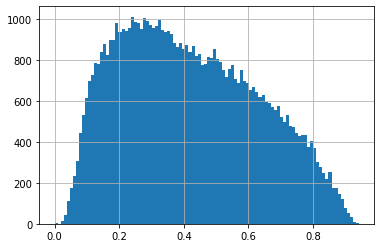

In [56]:
submission_result['TARGET'].hist(bins=100)

In [57]:
p=0.35
submission_result.loc[submission_result['TARGET']<p,'TARGET']=0
submission_result.loc[submission_result['TARGET']>1-p,'TARGET']=1

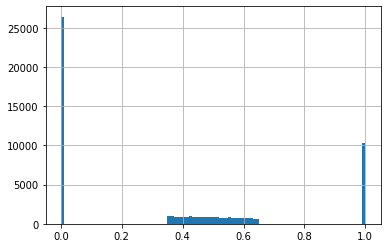

In [58]:
submission_result['TARGET'].hist(bins=100)

In [59]:
submission_result.to_csv('lower_sub.csv', index = False)

Importing data...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataing Features shape:  (171202, 201)
Testing Features shape:  (61500, 200)
There are 0 anomalies in the test data out of 61500 entries
Polynomial Features shape:  (171202, 35)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


EXT_SOURCE_2 EXT_SOURCE_3                -0.190619
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.187364
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.174604
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.169516
EXT_SOURCE_1 EXT_SOURCE_2                -0.165062
EXT_SOURCE_2                             -0.162383
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.155854
EXT_SOURCE_2^2                           -0.151487
EXT_SOURCE_1 EXT_SOURCE_3                -0.150418
EXT_SOURCE_3                             -0.142190
EXT_SOURCE_2^3                           -0.142178
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.138980
EXT_SOURCE_1^2 EXT_SOURCE_2              -0.138804
EXT_SOURCE_2 DAYS_BIRTH^2                -0.135825
EXT_SOURCE_3^2                           -0.129820
EXT_SOURCE_1^2 EXT_SOURCE_3              -0.127705
EXT_SOURCE_3 DAYS_BIRTH^2                -0.120932
EXT_SOURCE_3^3                           -0.117608
EXT_SOURCE_1 DAYS_BIRTH^2                -0.090729
EXT_SOURCE_1                   

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.766971	train's binary_logloss: 0.580479	valid's auc: 0.751337	valid's binary_logloss: 0.581559
[400]	train's auc: 0.783196	train's binary_logloss: 0.562322	valid's auc: 0.759142	valid's binary_logloss: 0.566889
[600]	train's auc: 0.795081	train's binary_logloss: 0.550665	valid's auc: 0.761109	valid's binary_logloss: 0.560158
[800]	train's auc: 0.803955	train's binary_logloss: 0.541525	valid's auc: 0.761886	valid's binary_logloss: 0.555798
[1000]	train's auc: 0.813215	train's binary_logloss: 0.53234	valid's auc: 0.763095	valid's binary_logloss: 0.549841
Early stopping, best iteration is:
[1080]	train's auc: 0.816128	train's binary_logloss: 0.529235	valid's auc: 0.763246	valid's binary_logloss: 0.550029


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.76758	train's binary_logloss: 0.580471	valid's auc: 0.750585	valid's binary_logloss: 0.585878
[400]	train's auc: 0.784315	train's binary_logloss: 0.561828	valid's auc: 0.757717	valid's binary_logloss: 0.571024
[600]	train's auc: 0.796	train's binary_logloss: 0.549814	valid's auc: 0.760007	valid's binary_logloss: 0.563985
[800]	train's auc: 0.804557	train's binary_logloss: 0.540786	valid's auc: 0.760785	valid's binary_logloss: 0.557874
Early stopping, best iteration is:
[778]	train's auc: 0.803902	train's binary_logloss: 0.541842	valid's auc: 0.760987	valid's binary_logloss: 0.559848


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.766179	train's binary_logloss: 0.581401	valid's auc: 0.754828	valid's binary_logloss: 0.581555
[400]	train's auc: 0.784487	train's binary_logloss: 0.561584	valid's auc: 0.760926	valid's binary_logloss: 0.569589
[600]	train's auc: 0.795837	train's binary_logloss: 0.549583	valid's auc: 0.76235	valid's binary_logloss: 0.558514
[800]	train's auc: 0.805273	train's binary_logloss: 0.540059	valid's auc: 0.763191	valid's binary_logloss: 0.553364
Early stopping, best iteration is:
[809]	train's auc: 0.805512	train's binary_logloss: 0.539702	valid's auc: 0.763284	valid's binary_logloss: 0.553954


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.770128	train's binary_logloss: 0.577989	valid's auc: 0.740191	valid's binary_logloss: 0.583355
[400]	train's auc: 0.787511	train's binary_logloss: 0.558548	valid's auc: 0.745851	valid's binary_logloss: 0.572009
[600]	train's auc: 0.798294	train's binary_logloss: 0.547601	valid's auc: 0.747578	valid's binary_logloss: 0.564673
[800]	train's auc: 0.806901	train's binary_logloss: 0.538219	valid's auc: 0.748468	valid's binary_logloss: 0.558823
Early stopping, best iteration is:
[890]	train's auc: 0.811619	train's binary_logloss: 0.533704	valid's auc: 0.749741	valid's binary_logloss: 0.556131


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.769	train's binary_logloss: 0.578809	valid's auc: 0.740017	valid's binary_logloss: 0.583576
[400]	train's auc: 0.785986	train's binary_logloss: 0.559845	valid's auc: 0.747607	valid's binary_logloss: 0.5699
[600]	train's auc: 0.797209	train's binary_logloss: 0.548504	valid's auc: 0.74962	valid's binary_logloss: 0.5625
[800]	train's auc: 0.80721	train's binary_logloss: 0.538125	valid's auc: 0.751699	valid's binary_logloss: 0.557239
Early stopping, best iteration is:
[820]	train's auc: 0.808134	train's binary_logloss: 0.537206	valid's auc: 0.751999	valid's binary_logloss: 0.555454
Baseline metrics
      fold     train     valid
0        0  0.816128  0.763246
1        1  0.803902  0.760987
2        2  0.805512  0.763284
3        3  0.811619  0.749741
4        4  0.808134  0.751999
5  overall  0.809059  0.757740


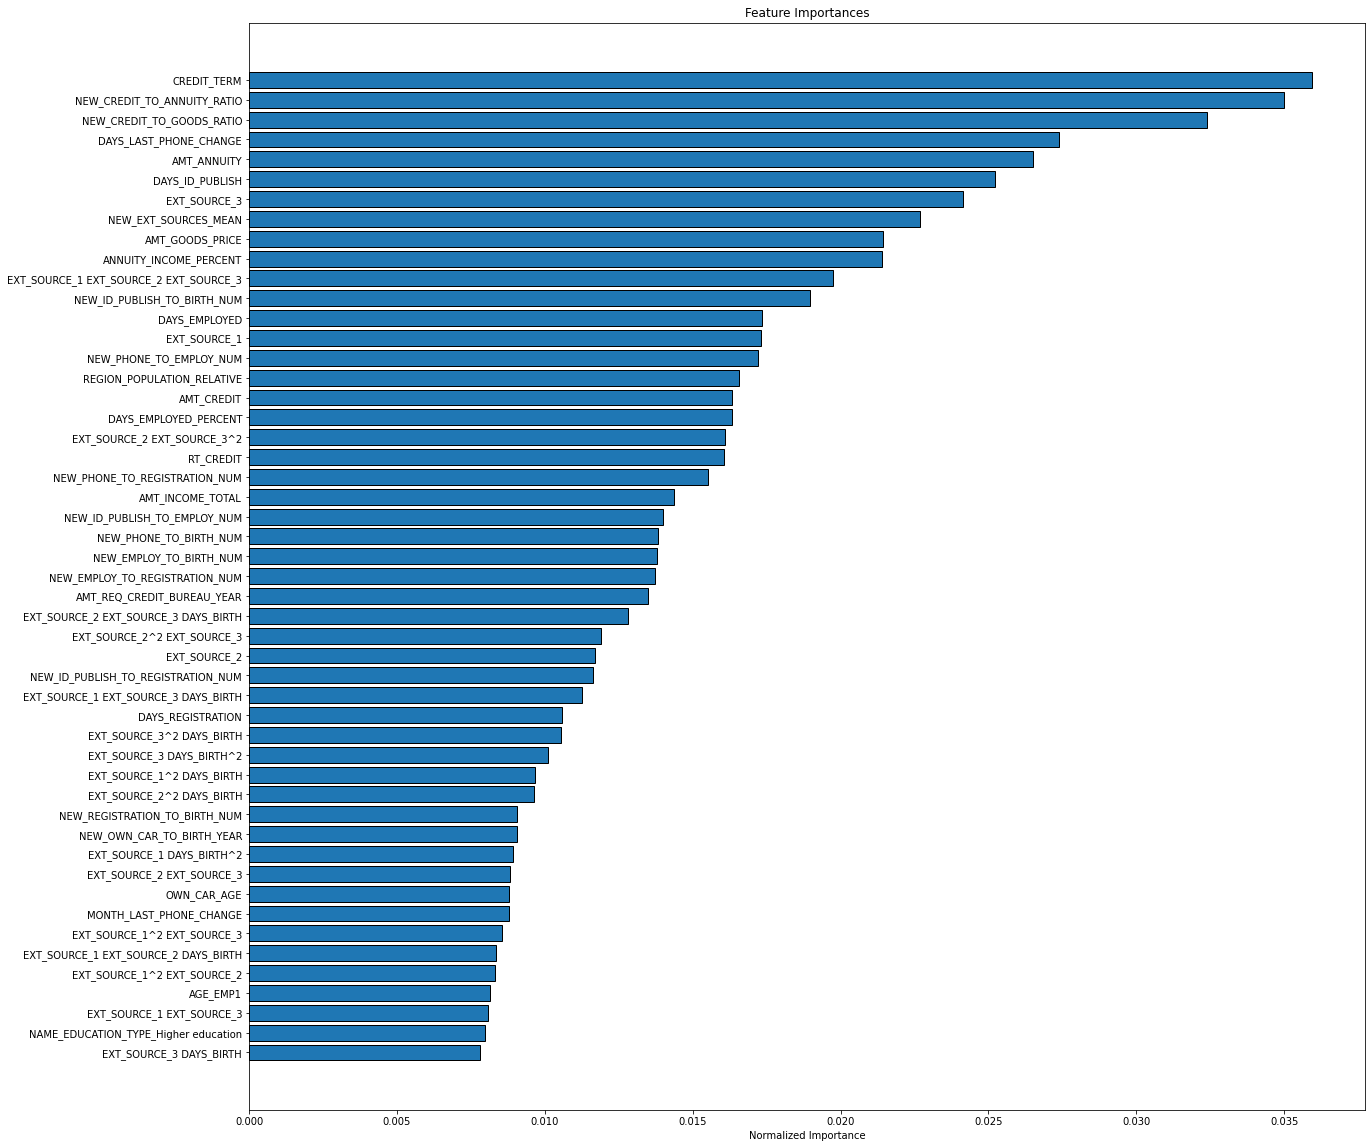

In [60]:
# -*- coding: utf-8 -*-
"""June28_1930_0_76315.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1UCEsc9CPQGjrpyvJpzQtujQO2wgiUIFd
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

print('Importing data...')
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
data = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/train.csv")
test = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/test.csv")

#test = test[test.columns[data.isnull().mean() < 0.85]]
#data = data[data.columns[data.isnull().mean() < 0.85]]

data['FLAG_NOT_EMPLOYED']=0
data.loc[data['DAYS_EMPLOYED']==365243,'FLAG_NOT_EMPLOYED']=1
#data.loc[data['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED']=np.NAN
test['FLAG_NOT_EMPLOYED']=0
test.loc[test['DAYS_EMPLOYED']==365243,'FLAG_NOT_EMPLOYED']=1
#test.loc[test['DAYS_EMPLOYED']==365243,'DAYS_EMPLOYED']=np.NAN

cols =list(test.columns)
cols



data['YEARS_BIRTH']=round(data['DAYS_BIRTH']/365)
test['YEARS_BIRTH']=round(test['DAYS_BIRTH']/365)

data['YEARS_ID_PUBLISH']=round(data['DAYS_ID_PUBLISH']/365)
test['YEARS_ID_PUBLISH']=round(test['DAYS_ID_PUBLISH']/365)

data['YEARS_REGISTRATION']=round(data['DAYS_REGISTRATION']/365)
test['YEARS_REGISTRATION']=round(test['DAYS_REGISTRATION']/365)


data['YEARS_EMPLOYED']=round(data['DAYS_EMPLOYED']/365)
test['YEARS_EMPLOYED']=round(test['DAYS_EMPLOYED']/365)



dict={}
for item in data['AMT_INCOME_TOTAL'].unique():
  dict[item]=data.loc[data['AMT_INCOME_TOTAL']==item,'SK_ID_CURR'].count()
df = pd.DataFrame.from_dict(dict,orient='index')

items = list(df[df[0]>10])

data['AMT_INCOME_TOTAL_2']=np.NAN
test['AMT_INCOME_TOTAL_2']=np.NAN
for item in items:
  data.loc[data['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL_2']=data.loc[data['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL']
  test.loc[test['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL_2']=test.loc[test['AMT_INCOME_TOTAL']==item,'AMT_INCOME_TOTAL']

data=pd.get_dummies(data,columns=['AMT_INCOME_TOTAL_2'])
test=pd.get_dummies(test,columns={'AMT_INCOME_TOTAL_2'})

data.loc[data['REGION_POPULATION_RELATIVE']>0.04,'REGION_POPULATION_RELATIVE'].unique()

data['REGION_POPULATION_RELATIVE_0.04622']=0
data['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE_0.04622']=1
data['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE']=np.nan

test['REGION_POPULATION_RELATIVE_0.04622']=0
test['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE_0.04622']=1
test['REGION_POPULATION_RELATIVE'==0.4622,'REGION_POPULATION_RELATIVE']=np.nan

data['REGION_POPULATION_RELATIVE_0.072508']=0
data['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE_0.072508']=1
data['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE']=np.nan

test['REGION_POPULATION_RELATIVE_0.072508']=0
test['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE_0.072508']=1
test['REGION_POPULATION_RELATIVE'==0.072508,'REGION_POPULATION_RELATIVE']=np.nan

data['OWN_CAR_AGE_64']=0
data['OWN_CAR_AGE'==64,'OWN_CAR_AGE_64']=1
data['OWN_CAR_AGE'==64,'OWN_CAR_AGE']=np.nan

test['OWN_CAR_AGE_64']=0
test['OWN_CAR_AGE'==64,'OWN_CAR_AGE_64']=1
test['OWN_CAR_AGE'==64,'OWN_CAR_AGE']=np.nan

data['OWN_CAR_AGE_65']=0
data['OWN_CAR_AGE'==65,'OWN_CAR_AGE_65']=1
data['OWN_CAR_AGE'==65,'OWN_CAR_AGE']=np.nan

test['OWN_CAR_AGE_65']=0
test['OWN_CAR_AGE'==65,'OWN_CAR_AGE_65']=1
test['OWN_CAR_AGE'==65,'OWN_CAR_AGE']=np.nan

data['LOW_DEFAULT_ORG']=0
data.loc[data['ORGANIZATION_TYPE']=='Industry: type 12','LOW_DEFAULT_ORG' ]=1
data.loc[data['ORGANIZATION_TYPE']=='Trade: type 4','LOW_DEFAULT_ORG' ]=1
test['LOW_DEFAULT_ORG']=0
test.loc[test['ORGANIZATION_TYPE']=='Industry: type 12','LOW_DEFAULT_ORG' ]=1
test.loc[test['ORGANIZATION_TYPE']=='Trade: type 4','LOW_DEFAULT_ORG' ]=1

data['HIGH_DEFAULT_ORG']=0
data.loc[data['ORGANIZATION_TYPE']=='Transport: type 3','HIGH_DEFAULT_ORG']=1
test['HIGH_DEFAULT_ORG']=0
test.loc[test['ORGANIZATION_TYPE']=='Transport: type 3','HIGH_DEFAULT_ORG']=1

# 欠測値であれば'_NAN'を加えたカラムを作る
def flag_isNan(column_target):
  if type(column_target)==str:
    data[column_target+'_NAN']=0
    test[column_target+'_NAN']=0
    #
    data.loc[data[column_target].isna(),column_target+'_NAN']=1
    test.loc[test[column_target].isna(),column_target+'_NAN']=1

list(test.dtypes[data.dtypes=='float'].keys())

for col in ['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'YEARS_BIRTH',
 'YEARS_ID_PUBLISH',
 'YEARS_REGISTRATION',
 'YEARS_EMPLOYED',
 #(False, 'REGION_POPULATION_RELATIVE'),
 #(False, 'OWN_CAR_AGE')
 ]:
  if (test.loc[test[col].isna(),'SK_ID_CURR'].count()>0):
    flag_isNan(col)

#for col in list(test.dtypes[data.dtypes!='float'].keys()):
#  if (test.loc[test[col].isna(),'SK_ID_CURR'].count()>0):
#    flag_isNan(col)

data['RT_CREDIT']=data['AMT_CREDIT']/data['AMT_INCOME_TOTAL']
test['RT_CREDIT']=test['AMT_CREDIT']/test['AMT_INCOME_TOTAL']

#data['FLAG_RT_CREDIT_OVER1']=0
#test['FLAG_RT_CREDIT_OVER1']=0
#data.loc[data['RT_CREDIT']>1,'FLAG_RT_CREDIT_OVER1']=1
#test.loc[data['RT_CREDIT']>1,'FLAG_RT_CREDIT_OVER1']=1

data['ROUND_RT_CREDIT']=round(data['RT_CREDIT'])
data['ROUND_RT_CREDIT'].fillna(0,inplace=True)
data.loc[data['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
data['ROUND_RT_CREDIT']=data['ROUND_RT_CREDIT'].astype(str)

data=pd.get_dummies(data,columns=['ROUND_RT_CREDIT'])

test['ROUND_RT_CREDIT']=round(test['RT_CREDIT'])
test['ROUND_RT_CREDIT'].fillna(0,inplace=True)
test.loc[test['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
test['ROUND_RT_CREDIT']=test['ROUND_RT_CREDIT'].astype(str)

test=pd.get_dummies(test,columns=['ROUND_RT_CREDIT'])

data['AGE_EMP']=data['YEARS_BIRTH']-data['YEARS_EMPLOYED']
test['AGE_EMP']=test['YEARS_BIRTH']-test['YEARS_EMPLOYED']

# 26歳までの上昇局面とそれ以降の下降局面を別のカラムにする
data['AGE_EMP1']=np.NAN
test['AGE_EMP1']=np.NAN
data.loc[data['AGE_EMP']<-26,'AGE_EMP1']=data['AGE_EMP']
test.loc[test['AGE_EMP']<-26,'AGE_EMP1']=test['AGE_EMP']
data.loc[data['AGE_EMP']<-26,'AGE_EMP']=np.NAN
test.loc[test['AGE_EMP']<-26,'AGE_EMP']=np.NAN

#data['TMP_FLAG_OWN_REALTY']=data['FLAG_OWN_REALTY']
#data.loc[data['TMP_FLAG_OWN_REALTY'].isna(),'TMP_FLAG_OWN_REALTY']='O'
#data['ROUND_AMT_INCOME_TOTAL']=round(data['AMT_INCOME_TOTAL']/100000)
#data.loc[data['ROUND_AMT_INCOME_TOTAL']>6,'ROUND_AMT_INCOME_TOTAL']=6
#data['ROUND_AMT_INCOME_TOTAL']=data['ROUND_AMT_INCOME_TOTAL'].astype(str)
#data['ROUND_RT_CREDIT']=round(data['RT_CREDIT'])
#data.loc[data['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
#data['ROUND_RT_CREDIT'].fillna(0,inplace=True)
#data['ROUND_RT_CREDIT']=data['ROUND_RT_CREDIT'].astype(str)
#data['REALTY_INCOME_CREDIT']=data['TMP_FLAG_OWN_REALTY']+data['ROUND_AMT_INCOME_TOTAL']+data['ROUND_RT_CREDIT']
#data.drop(['TMP_FLAG_OWN_REALTY'], axis=1, inplace=True)
#data.drop(['ROUND_AMT_INCOME_TOTAL'], axis=1, inplace=True)
#data.drop(['ROUND_RT_CREDIT'], axis=1, inplace=True)

#test['TMP_FLAG_OWN_REALTY']=test['FLAG_OWN_REALTY']
#test.loc[test['TMP_FLAG_OWN_REALTY'].isna(),'TMP_FLAG_OWN_REALTY']='O'
#test['ROUND_AMT_INCOME_TOTAL']=round(test['AMT_INCOME_TOTAL']/100000)
#test['ROUND_AMT_INCOME_TOTAL'].fillna(0,inplace=True)
#test.loc[test['ROUND_AMT_INCOME_TOTAL']>6,'ROUND_AMT_INCOME_TOTAL']=6
#test['ROUND_AMT_INCOME_TOTAL']=test['ROUND_AMT_INCOME_TOTAL'].astype(str)
#test['ROUND_RT_CREDIT']=round(test['RT_CREDIT'])
#test.loc[test['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
#test['ROUND_RT_CREDIT'].fillna(0,inplace=True)
#test['ROUND_RT_CREDIT']=test['ROUND_RT_CREDIT'].astype(str)
#test['REALTY_INCOME_CREDIT']=test['TMP_FLAG_OWN_REALTY']+test['ROUND_AMT_INCOME_TOTAL']+test['ROUND_RT_CREDIT']

#data['ROUND_EXT_SOURCE_1']=round(data['EXT_SOURCE_1']*100)
#data['ROUND_EXT_SOURCE_2']=round(data['EXT_SOURCE_2']*100)
#data['ROUND_EXT_SOURCE_3']=round(data['EXT_SOURCE_3']*100)

#test['ROUND_EXT_SOURCE_1']=round(test['EXT_SOURCE_1']*100)
#test['ROUND_EXT_SOURCE_2']=round(test['EXT_SOURCE_2']*100)
#test['ROUND_EXT_SOURCE_3']=round(test['EXT_SOURCE_3']*100)

t1=data.loc[data['TARGET']==1]
t0=data.loc[data['TARGET']==0]
ta=data
def addColumnOfNumber(column_target):
    column_new = 'NEW_NUM_'+column_target
    cats = ta[column_target].unique()

    dict={}
    for cat in cats:
      dict[cat]=(t1.loc[ta[column_target]==cat,'SK_ID_CURR'].count()/ta.loc[ta[column_target]==cat,'SK_ID_CURR'].count()).astype(str)

    data[column_new]=data[column_target]
    test[column_new]=test[column_target]

    data[column_new]=data[column_new].map(dict)
    test[column_new]=test[column_new].map(dict)

    data[column_new]=data[column_new].astype(float)
    test[column_new]=test[column_new].astype(float)

#addColumnOfNumber('REALTY_INCOME_CREDIT')
#addColumnOfNumber('ROUND_EXT_SOURCE_1')
#addColumnOfNumber('ROUND_EXT_SOURCE_2')
#addColumnOfNumber('ROUND_EXT_SOURCE_3')

# Create an anomalous flag column
data['DAYS_EMPLOYED_ANOM'] = data["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
data['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# Create an anomalous flag column
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

data['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)
test['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

data['YEARS_LAST_PHONE_CHANGE']=round(data['DAYS_LAST_PHONE_CHANGE']/365)
test['YEARS_LAST_PHONE_CHANGE']=round(test['DAYS_LAST_PHONE_CHANGE']/365)

data['MONTH_LAST_PHONE_CHANGE']=round(data['DAYS_LAST_PHONE_CHANGE']/30)
test['MONTH_LAST_PHONE_CHANGE']=round(test['DAYS_LAST_PHONE_CHANGE']/30)

#Separate target variable
y = data['TARGET']
del data['TARGET']

#One-hot encoding of categorical features in data and test sets
categorical_features = [col for col in data.columns if data[col].dtype == 'object']

one_hot_df = pd.concat([data,test])
one_hot_df = pd.get_dummies(one_hot_df, columns=categorical_features)

data = one_hot_df.iloc[:data.shape[0],:]
test = one_hot_df.iloc[data.shape[0]:,]

# Align data and test

data_labels = y

# Align the dataing and testing data, keep only columns present in both dataframes
data, test = data.align(test, join = 'inner', axis = 1)

# Add the target back in
data['TARGET'] = y

print('dataing Features shape: ', data.shape)
print('Testing Features shape: ', test.shape)

test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (test["DAYS_EMPLOYED_ANOM"].sum(), len(test)))

#data['EXT_SOURCE_1_y']

#Polynomial Features

# Make a new dataframe for polynomial features
poly_features = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# data the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(20))
print(poly_corrs.tail(20))

# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into dataing dataframe
poly_features['SK_ID_CURR'] = data['SK_ID_CURR']
app_train_poly = data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']
app_test_poly = test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('dataing data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

app_train_poly.head()

app_train_poly=app_train_poly.rename(columns={'EXT_SOURCE_1_x':'EXT_SOURCE_1','EXT_SOURCE_2_x':'EXT_SOURCE_2','EXT_SOURCE_3_x':'EXT_SOURCE_3','DAYS_BIRTH_x':'DAYS_BIRTH'})
#app_train_poly=app_train_poly.drop('1',inplace=True)

app_test_poly=app_test_poly.rename(columns={'EXT_SOURCE_1_x':'EXT_SOURCE_1','EXT_SOURCE_2_x':'EXT_SOURCE_2','EXT_SOURCE_3_x':'EXT_SOURCE_3','DAYS_BIRTH_x':'DAYS_BIRTH'})

app_test_poly.drop('1',axis=1,inplace=True)
app_train_poly.drop('1',axis=1,inplace=True)

#app_train_poly['NAME_TYPE_SUITE_Spouse, partner_x']

# check and remove constant columns
#colsToRemove = []
#for col in app_train_poly.columns:
#    if col != 'SK_ID_CURR' and col != 'TARGET':
#        if app_train_poly[col].std() == 0: 
#            colsToRemove.append(col)
        
# remove constant columns in the training set
#app_train_poly.drop(colsToRemove, axis=1, inplace=True)

# remove constant columns in the test set
#app_test_poly.drop(colsToRemove, axis=1, inplace=True) 

#print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
#print(colsToRemove)

#app_train_domain['SK_ID_CURR']

# create temp DF
#data1 = pd.read_csv('../input/application_train.csv')
#test1 = pd.read_csv('../input/application_test.csv')

#app_train_domain = app_test_domain.drop('SK_ID_PREV_x',axis=1)
#app_test_domain = app_test_domain.drop('SK_ID_PREV_x',axis=1)

#app_train_domain = app_test_domain.drop('SK_ID_PREV_y',axis=1)
#app_test_domain = app_test_domain.drop('SK_ID_PREV_y',axis=1)

#app_train_poly['AMT_CREDIT'] = data1['AMT_CREDIT']
#app_test_poly['AMT_CREDIT'] = test1['AMT_CREDIT']
#app_train_poly['AMT_GOODS_PRICE'] = data1['AMT_GOODS_PRICE']
#app_test_poly['AMT_GOODS_PRICE'] = test1['AMT_GOODS_PRICE']
app_train_poly=app_train_poly.rename(columns={'AMT_CREDIT_x':'AMT_CREDIT','AMT_GOODS_PRICE_x':'AMT_GOODS_PRICE'})
app_test_poly=app_test_poly.rename(columns={'AMT_CREDIT_x':'AMT_CREDIT','AMT_GOODS_PRICE_x':'AMT_GOODS_PRICE'})

#app_train_poly['AMT_ANNUITY_x']

app_train_domain = app_train_poly.copy()
app_test_domain = app_test_poly.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
app_train_domain['NEW_CREDIT_TO_ANNUITY_RATIO'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_ANNUITY']
app_train_domain['NEW_CREDIT_TO_GOODS_RATIO'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_GOODS_PRICE']
app_train_domain['NEW_EXT_SOURCES_MEAN'] = app_train_domain[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
app_train_domain['NEW_EMPLOY_TO_BIRTH_RATIO'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
#
app_train_domain['NEW_EMPLOY_TO_BIRTH_NUM'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_EMPLOYED']
app_train_domain['NEW_PHONE_TO_BIRTH_NUM'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_LAST_PHONE_CHANGE']
app_train_domain['NEW_REGISTRATION_TO_BIRTH_NUM'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_REGISTRATION']
app_train_domain['NEW_ID_PUBLISH_TO_BIRTH_NUM'] = app_train_domain['DAYS_BIRTH'] - app_train_domain['DAYS_ID_PUBLISH']
app_train_domain['NEW_PHONE_TO_REGISTRATION_NUM'] = app_train_domain['DAYS_REGISTRATION'] - app_train_domain['DAYS_LAST_PHONE_CHANGE']
app_train_domain['NEW_EMPLOY_TO_REGISTRATION_NUM'] = app_train_domain['DAYS_REGISTRATION'] - app_train_domain['DAYS_EMPLOYED']
app_train_domain['NEW_ID_PUBLISH_TO_REGISTRATION_NUM'] = app_train_domain['DAYS_REGISTRATION'] - app_train_domain['DAYS_ID_PUBLISH']
app_train_domain['NEW_PHONE_TO_EMPLOY_NUM'] = app_train_domain['DAYS_EMPLOYED'] - app_train_domain['DAYS_LAST_PHONE_CHANGE']
app_train_domain['NEW_ID_PUBLISH_TO_EMPLOY_NUM'] = app_train_domain['DAYS_EMPLOYED'] - app_train_domain['DAYS_ID_PUBLISH']
app_train_domain['NEW_REGION_RATING_CLIENT_NUM'] = app_train_domain['REGION_RATING_CLIENT_W_CITY'] - app_train_domain['REGION_RATING_CLIENT']
app_train_domain['NEW_FAM_MEMBERS_NUM'] = app_train_domain['CNT_FAM_MEMBERS'] - app_train_domain['CNT_CHILDREN']
app_train_domain['NEW_EMPLOY_TO_BIRTH_YEAR'] = app_train_domain['YEARS_BIRTH'] - app_train_domain['YEARS_EMPLOYED']
app_train_domain['NEW_PHONE_TO_BIRTH_YEAR'] = app_train_domain['YEARS_BIRTH'] - app_train_domain['YEARS_LAST_PHONE_CHANGE']
app_train_domain['NEW_REGISTRATION_TO_BIRTH_YEAR'] = app_train_domain['YEARS_BIRTH'] - app_train_domain['YEARS_REGISTRATION']
app_train_domain['NEW_ID_PUBLISH_TO_BIRTH_YEAR'] = app_train_domain['YEARS_BIRTH'] - app_train_domain['YEARS_ID_PUBLISH']
app_train_domain['NEW_OWN_CAR_TO_BIRTH_YEAR'] = app_train_domain['YEARS_BIRTH'] - app_train_domain['OWN_CAR_AGE']
app_train_domain['NEW_PHONE_TO_REGISTRATION_YEAR'] = app_train_domain['YEARS_REGISTRATION'] - app_train_domain['YEARS_LAST_PHONE_CHANGE']
app_train_domain['NEW_EMPLOY_TO_REGISTRATION_YEAR'] = app_train_domain['YEARS_REGISTRATION'] - app_train_domain['YEARS_EMPLOYED']
app_train_domain['NEW_ID_PUBLISH_TO_REGISTRATION_YEAR'] = app_train_domain['YEARS_REGISTRATION'] - app_train_domain['YEARS_ID_PUBLISH']
app_train_domain['NEW_OWN_CAR_TO_REGISTRATION_YEAR'] = app_train_domain['YEARS_REGISTRATION'] - app_train_domain['OWN_CAR_AGE']
app_train_domain['NEW_PHONE_TO_EMPLOY_YEAR'] = app_train_domain['YEARS_EMPLOYED'] - app_train_domain['YEARS_LAST_PHONE_CHANGE']
app_train_domain['NEW_ID_PUBLISH_TO_EMPLOY_YEAR'] = app_train_domain['YEARS_EMPLOYED'] - app_train_domain['YEARS_ID_PUBLISH']
app_train_domain['NEW_OWN_CAR_TO_EMPLOY_YEAR'] = app_train_domain['YEARS_EMPLOYED'] - app_train_domain['OWN_CAR_AGE']
app_train_domain['NEW_ID_PUBLISH_TO_OWN_CAR'] = app_train_domain['OWN_CAR_AGE'] - app_train_domain['YEARS_ID_PUBLISH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

app_test_domain['NEW_CREDIT_TO_ANNUITY_RATIO'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_ANNUITY']
app_test_domain['NEW_CREDIT_TO_GOODS_RATIO'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_GOODS_PRICE']
app_test_domain['NEW_EXT_SOURCES_MEAN'] = app_test_domain[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
app_test_domain['NEW_EMPLOY_TO_BIRTH_RATIO'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

#
app_test_domain['NEW_EMPLOY_TO_BIRTH_NUM'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_EMPLOYED']
app_test_domain['NEW_PHONE_TO_BIRTH_NUM'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_LAST_PHONE_CHANGE']
app_test_domain['NEW_REGISTRATION_TO_BIRTH_NUM'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_REGISTRATION']
app_test_domain['NEW_ID_PUBLISH_TO_BIRTH_NUM'] = app_test_domain['DAYS_BIRTH'] - app_test_domain['DAYS_ID_PUBLISH']
app_test_domain['NEW_PHONE_TO_REGISTRATION_NUM'] = app_test_domain['DAYS_REGISTRATION'] - app_test_domain['DAYS_LAST_PHONE_CHANGE']
app_test_domain['NEW_EMPLOY_TO_REGISTRATION_NUM'] = app_test_domain['DAYS_REGISTRATION'] - app_test_domain['DAYS_EMPLOYED']
app_test_domain['NEW_ID_PUBLISH_TO_REGISTRATION_NUM'] = app_test_domain['DAYS_REGISTRATION'] - app_test_domain['DAYS_ID_PUBLISH']
app_test_domain['NEW_PHONE_TO_EMPLOY_NUM'] = app_test_domain['DAYS_EMPLOYED'] - app_test_domain['DAYS_LAST_PHONE_CHANGE']
app_test_domain['NEW_ID_PUBLISH_TO_EMPLOY_NUM'] = app_test_domain['DAYS_EMPLOYED'] - app_test_domain['DAYS_ID_PUBLISH']
app_test_domain['NEW_REGION_RATING_CLIENT_NUM'] = app_test_domain['REGION_RATING_CLIENT_W_CITY'] - app_test_domain['REGION_RATING_CLIENT']
app_test_domain['NEW_FAM_MEMBERS_NUM'] = app_test_domain['CNT_FAM_MEMBERS'] - app_test_domain['CNT_CHILDREN']
app_test_domain['NEW_EMPLOY_TO_BIRTH_YEAR'] = app_test_domain['YEARS_BIRTH'] - app_test_domain['YEARS_EMPLOYED']
app_test_domain['NEW_PHONE_TO_BIRTH_YEAR'] = app_test_domain['YEARS_BIRTH'] - app_test_domain['YEARS_LAST_PHONE_CHANGE']
app_test_domain['NEW_REGISTRATION_TO_BIRTH_YEAR'] = app_test_domain['YEARS_BIRTH'] - app_test_domain['YEARS_REGISTRATION']
app_test_domain['NEW_ID_PUBLISH_TO_BIRTH_YEAR'] = app_test_domain['YEARS_BIRTH'] - app_test_domain['YEARS_ID_PUBLISH']
app_test_domain['NEW_OWN_CAR_TO_BIRTH_YEAR'] = app_test_domain['YEARS_BIRTH'] - app_test_domain['OWN_CAR_AGE']
app_test_domain['NEW_PHONE_TO_REGISTRATION_YEAR'] = app_test_domain['YEARS_REGISTRATION'] - app_test_domain['YEARS_LAST_PHONE_CHANGE']
app_test_domain['NEW_EMPLOY_TO_REGISTRATION_YEAR'] = app_test_domain['YEARS_REGISTRATION'] - app_test_domain['YEARS_EMPLOYED']
app_test_domain['NEW_ID_PUBLISH_TO_REGISTRATION_YEAR'] = app_test_domain['YEARS_REGISTRATION'] - app_test_domain['YEARS_ID_PUBLISH']
app_test_domain['NEW_OWN_CAR_TO_REGISTRATION_YEAR'] = app_test_domain['YEARS_REGISTRATION'] - app_test_domain['OWN_CAR_AGE']
app_test_domain['NEW_PHONE_TO_EMPLOY_YEAR'] = app_test_domain['YEARS_EMPLOYED'] - app_test_domain['YEARS_LAST_PHONE_CHANGE']
app_test_domain['NEW_ID_PUBLISH_TO_EMPLOY_YEAR'] = app_test_domain['YEARS_EMPLOYED'] - app_test_domain['YEARS_ID_PUBLISH']
app_test_domain['NEW_OWN_CAR_TO_EMPLOY_YEAR'] = app_test_domain['YEARS_EMPLOYED'] - app_test_domain['OWN_CAR_AGE']
app_test_domain['NEW_ID_PUBLISH_TO_OWN_CAR'] = app_test_domain['OWN_CAR_AGE'] - app_test_domain['YEARS_ID_PUBLISH']

app_train_domain['TARGET'] = poly_target
print('Training data with polynomial features shape: ', app_train_domain.shape)
print('Testing data with polynomial features shape:  ', app_test_domain.shape)

#app_train_domain = app_train_domain[app_train_domain.columns[app_train_domain.isnull().mean() < 0.80]]
#app_test_domain = app_test_domain[app_test_domain.columns[app_test_domain.isnull().mean() < 0.80]]
#print('Training data with polynomial features shape: ', app_train_domain.shape)
#print('Testing data with polynomial features shape:  ', app_test_domain.shape)

#app_train_domain = app_test_domain.drop('AMT_ANNUITY',axis=1)
#app_test_domain = app_test_domain.drop('AMT_ANNUITY',axis=1)

#app_train_domain['TARGET']

app_train_domain['TARGET'] = poly_target
print('Training data with polynomial features shape: ', app_train_domain.shape)
print('Testing data with polynomial features shape:  ', app_test_domain.shape)

#app_train_domain = app_train_domain.reindex(
 #   np.random.permutation(app_train_domain.index))

#app_train_domain=app_train_domain.drop('TARGET',axis=1)
#app_train_domain = np.log1p(app_train_domain)
#app_test_domain=np.log1p(app_test_domain)
#print('Training data with polynomial features shape: ', app_train_domain.shape)
#print('Testing data with polynomial features shape:  ', app_test_domain.shape)

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds =5 ):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, nthread=4,objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.015, 
                                   reg_alpha = 0.041545473, reg_lambda = 0.1, 
                                   n_jobs = -1, random_state = 50,num_leaves=32,colsample_bytree=.9497036,subsample=.8715623,
                                  max_depth=5,min_split_gain=.0222415,min_child_weight=39.3259775,max_bin=200,num_boost_round=3000,min_data_in_leaf=100,bagging_fraction=0.5,bagging_freq=10)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

submission, fi, metrics = model(app_train_domain, app_test_domain)
print('Baseline metrics')
print(metrics)

"""June27_11:00
      fold     train     valid

* 0    0.812380    0.763470
* 1    0.800873    0.761361
* 2    0.829364    0.763497
* 3    0.804734    0.749407
* 4    0.808092    0.752702
*  overall  0.811088  0.758063

This is 0.76335 on leader board

June27　1530　（Ext_1-3を100で導入）
      fold     train     valid
*        0  0.812034  0.763665
*        1  0.814457  0.761841
*        2  0.795298  0.761181
*        3  0.804273  0.749477
*        4  0.806116  0.753385
*  overall  0.806436  0.757831

June27 1630 (Realty_Income_Credit_Num)

      fold     train     valid
*        0  0.811275  0.764974
*        1  0.810877  0.763801
*        2  0.806269  0.763429
*        3  0.818493  0.751784
*        4  0.807860  0.754887
*  overall  0.810955  0.759639

June27 1700 (Ext1_3 Num)

      fold     train     valid
*        0  0.812888  0.763947
*        1  0.803323  0.762918
*        2  0.821568  0.765399
*        3  0.817804  0.753279
*        4  0.808146  0.754978
*  overall  0.812746  0.760012

This is 0.7596 on Public Leader Board

      fold     train     valid
*        0  0.811275  0.764974
*        1  0.810877  0.763801
*        2  0.806269  0.763429
*        3  0.818493  0.751784
*        4  0.807860  0.754887
*  overall  0.810955  0.759639

This is 0.75981 on Public Leader Board

This is 0.76315 on Public Leader Board

      fold     train     valid
*        0  0.811888  0.763755
*        1  0.807078  0.761591
*        2  0.829285  0.763293
*        3  0.804734  0.749407
*        4  0.808156  0.752579
*  overall  0.812228  0.758108


"""

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (20, 20))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:50]))), 
            df['importance_normalized'].head(50), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:50]))))
    ax.set_yticklabels(df['feature'].head(50))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

fi_sorted = plot_feature_importances(fi)

submission.to_csv('second_sub.csv', index = False)



# 良い成績の結果と属性を結合

In [73]:
#lower=pd.read_csv('lower_sub.csv')
#lower.rename(columns={'SK_ID_CURR':'LOW_ID','TARGET':'LOW_RES'},inplace=True)
submission.rename(columns={'SK_ID_CURR':'HIGH_ID','TARGET':'HIGH_RES'},inplace=True)
test = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/test.csv")
#df = pd.concat([lower,submission,test],axis=1)
df = pd.concat([submission,test],axis=1)

In [74]:
test.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIA

In [75]:
df.drop(['HIGH_ID'],axis=1, inplace=True)

リボルビング・ローンの10回返済のデフォルト率はゼロである。

実際には10回返済と20回返済しかないが、15未満の条件で10回返済のみが選択される。

In [76]:
df['TARGET']=df['HIGH_RES']
df.loc[(df['NAME_CONTRACT_TYPE']!='Cash loans')&(df['AMT_CREDIT']/df['AMT_ANNUITY']<15),'TARGET']=0

In [77]:
final=df[['SK_ID_CURR','TARGET']]
final.to_csv('final.csv',index=False)